The command is to remove if the directory exist, this ensures clean and consistent starting point before cloning

In [1]:
!if [ -d cs294-158-ssl ]; then rm -Rf cs294-158-ssl; fi

Clone and pip the directory

In [2]:
!git clone https://github.com/wilson1yan/cs294-158-ssl
!pip install cs294-158-ssl/

Cloning into 'cs294-158-ssl'...
remote: Enumerating objects: 611, done.
remote: Counting objects: 100% (189/189), done.
remote: Compressing objects: 100% (136/136), done.
remote: Total 611 (delta 115), reused 119 (delta 53), pack-reused 422
Receiving objects: 100% (611/611), 3.11 MiB | 7.33 MiB/s, done.
Resolving deltas: 100% (424/424), done.
Processing ./cs294-158-ssl
  Preparing metadata (setup.py) ... done
  Created wheel for deepul-helper: filename=deepul_helper-0.1.0-py3-none-any.whl size=25298 sha256=810891acbc789c51434f860846a11ca013e5c3daee21046a6e54ff7d46fc732a
  Stored in directory: /root/.cache/pip/wheels/e3/df/97/281e32d717214451862e0e558746de423b9ef530b7376421e2
Successfully built deepul-helper
  Attempting uninstall: deepul-helper
    Found existing installation: deepul-helper 0.1.0
    Uninstalling deepul-helper-0.1.0:
      Successfully uninstalled deepul-helper-0.1.0


Change working directory

In [3]:
import os
os.chdir('cs294-158-ssl') # use .. to go  back in wd

In [4]:
current_directory = os.getcwd()
print("Current working directory:", current_directory)

Current working directory: /content/cs294-158-ssl


Use gdown to take the data set from google drive

In [5]:
!pip install gdown
import gdown
gdown.download('https://drive.google.com/uc?id=1_3pQdiYZCI-Jybdjj_54OQZmclbddNBk', 'data.zip', quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1_3pQdiYZCI-Jybdjj_54OQZmclbddNBk
From (redirected): https://drive.google.com/uc?id=1_3pQdiYZCI-Jybdjj_54OQZmclbddNBk&confirm=t&uuid=51a5440b-b712-41cb-af16-442f3453165a
To: /content/cs294-158-ssl/data.zip
100%|██████████| 4.23G/4.23G [01:02<00:00, 67.4MB/s]


'data.zip'

In [6]:
!unzip -qq data.zip

In [7]:
!rm data.zip

In [8]:
!ls

build			   environment.yml  setup.py
create_imagenet_subset.py  palette.pkl	    train_segmentation.py
data			   README.md	    train_self_supervised_task.py
deepul_helper		   run
deepul_helper.egg-info	   sample_images


In [9]:
gdown.download("https://drive.google.com/uc?id=1GPQoG4r_zLyOzYrY-YUTl-6EUkCsb99J", "results.zip", quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1GPQoG4r_zLyOzYrY-YUTl-6EUkCsb99J
From (redirected): https://drive.google.com/uc?id=1GPQoG4r_zLyOzYrY-YUTl-6EUkCsb99J&confirm=t&uuid=ac6d5af9-1f04-4b33-9cb3-1eae785faaf0
To: /content/cs294-158-ssl/results.zip
100%|██████████| 2.64G/2.64G [00:35<00:00, 73.4MB/s]


'results.zip'

In [10]:
!unzip results.zip

Archive:  results.zip
   creating: results/
   creating: results/cifar10_context_encoder/
  inflating: results/cifar10_context_encoder/checkpoint.pth.tar  
  inflating: results/cifar10_context_encoder/model_best.pth.tar  
   creating: results/cifar10_rotation/
  inflating: results/cifar10_rotation/checkpoint.pth.tar  
  inflating: results/cifar10_rotation/model_best.pth.tar  
   creating: results/cifar10_simclr/
  inflating: results/cifar10_simclr/checkpoint.pth.tar  
  inflating: results/cifar10_simclr/model_best.pth.tar  
   creating: results/imagenet100_simclr/
  inflating: results/imagenet100_simclr/checkpoint.pth.tar  
  inflating: results/imagenet100_simclr/model_best.pth.tar  
   creating: results/imagenet100_simclr/segmentation/
  inflating: results/imagenet100_simclr/segmentation/epoch0.png  
  inflating: results/imagenet100_simclr/segmentation/epoch10.png  
  inflating: results/imagenet100_simclr/segmentation/epoch100.png  
  inflating: results/imagenet100_simclr/segmentation

In [11]:
!rm results.zip

Comes from the cs294-158-ssl

In [12]:
from deepul_helper.demos import load_model_and_data, evaluate_accuracy, display_nearest_neighbors, show_context_encoder_inpainting

To visualize context encoder inpainting

In [13]:
%matplotlib inline

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class ContextEncoder(nn.Module):
    metrics = ['Loss']
    metrics_fmt = [':.4e'] # Format metrices numerical value as exponent with 4 digits after decimal point

    def __init__(self, dataset, n_classes):
        super().__init__() # Call constructor of the superclass
        input_channels = 3 # 3 Channel input
        self.latent_dim = 4000 # Dimensionality of LS set to 4K

        # Encodes the masked image
        self.encoder = nn.Sequential(
            # 128 x 128 Input
            nn.Conv2d(input_channels, 64, 4, stride=2, padding=1), # 64 x 64
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 64, 4, stride=2, padding=1), # 32 x 32
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, stride=2, padding=1), # 16 x 16
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, stride=2, padding=1), # 8 x 8
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, stride=2, padding=1), # 4 x 4
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, self.latent_dim, 4) # 1 x 1
        )

        # Only reconstructs the masked part of the image and not the whole image
        self.decoder = nn.Sequential(
           nn.BatchNorm2d(self.latent_dim),
           nn.ReLU(inplace=True),
           nn.ConvTranspose2d(self.latent_dim, 512, 4, stride=1, padding=0), # 4 x 4
           nn.BatchNorm2d(512),
           nn.ReLU(inplace=True),
           nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1), # 8 x 8
           nn.BatchNorm2d(256),
           nn.ReLU(inplace=True),
           nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1), # 16 x 16
           nn.BatchNorm2d(128),
           nn.ReLU(inplace=True),
           nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1), # 32 x 32
           nn.BatchNorm2d(64),
           nn.ReLU(inplace=True),
           nn.ConvTranspose2d(64, input_channels, 4, stride=2, padding=1), # 64 x 64
           nn.Tanh()
        )

        self.dataset = dataset
        self.n_classes = n_classes

    def construct_classifier(self):
        classifier = nn.Sequential(
            nn.Flatten(),
            nn.BatchNorm1d(self.latent_dim, affine=False),
            nn.Linear(self.latent_dim, self.n_classes)
        )
        return classifier

    def forward(self, images):
        # Extract a 64 x 64 center from 128 x 128 image
        images_center = images[:, :, 32:32+64, 32:32+64].clone()
        images_masked = images.clone()
        # Mask out a 64 x 64 center with slight overlap
        images_masked[:, 0, 32+4:32+64-4, 32+4:32+64-4] = 2 * 117.0/255.0 - 1.0
        images_masked[:, 1, 32+4:32+64-4, 32+4:32+64-4] = 2 * 104.0/255.0 - 1.0
        images_masked[:, 2, 32+4:32+64-4, 32+4:32+64-4] = 2 * 123.0/255.0 - 1.0

        z = self.encoder(images_masked)
        center_recon = self.decoder(z)

        return dict(Loss=F.mse_loss(center_recon, images_center)), torch.flatten(z, 1)

    def encode(self, images):
        images_masked = images
        images_masked[:, 0, 32+4:32+64-4, 32+4:32+64-4] = 2 * 117.0/255.0 - 1.0
        images_masked[:, 1, 32+4:32+64-4, 32+4:32+64-4] = 2 * 104.0/255.0 - 1.0
        images_masked[:, 2, 32+4:32+64-4, 32+4:32+64-4] = 2 * 123.0/255.0 - 1.0
        return self.encoder(images_masked)

    def reconstruct(self, images):
        images_center = images[:, :, 32:32+64, 32:32+64].clone()
        images_masked = images.clone()
        images_masked[:, 0, 32+4:32+64 - 4, 32+4:32+64-4] = 2 * 117.0/255.0 - 1.0
        images_masked[:, 1, 32+4:32+64 - 4, 32+4:32+64-4] = 2 * 104.0/255.0 - 1.0
        images_masked[:, 2, 32+4:32+64 - 4, 32+4:32+64-4] = 2 * 123.0/255.0 - 1.0

        z = self.encoder(images_masked)
        center_recon = self.decoder(z)

        images_recon = images_masked.clone()
        images_recon[:, :, 32:32+64, 32:32+64] = center_recon
        return images_masked, images_recon

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


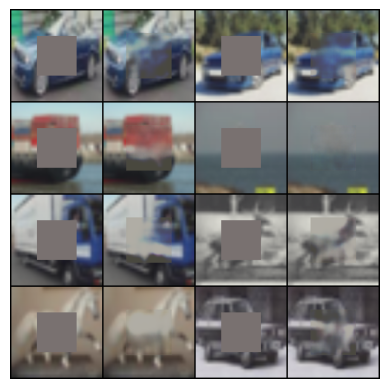

In [15]:
show_context_encoder_inpainting()

In [16]:
model, linear_classifier, train_loader, test_loader = load_model_and_data('context_encoder')
evaluate_accuracy(model, linear_classifier, train_loader, test_loader)

Files already downloaded and verified
Files already downloaded and verified
Train Set
Top 1 Accuracy: 53.236, Top 5 Accuracy: 94.094

Test Set
Top 1 Accuracy: 45.77, Top 5 Accuracy: 90.29



Image 1


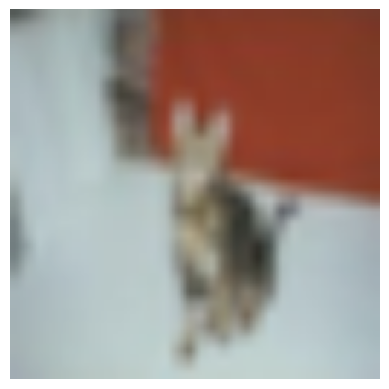

Top 16 Nearest Neighbors (in latent space)


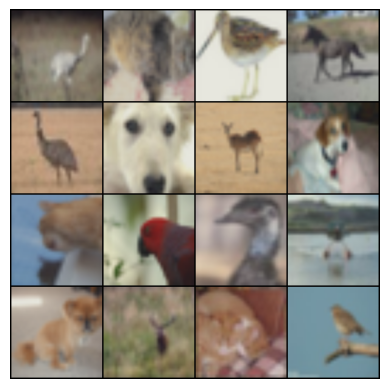

Image 2


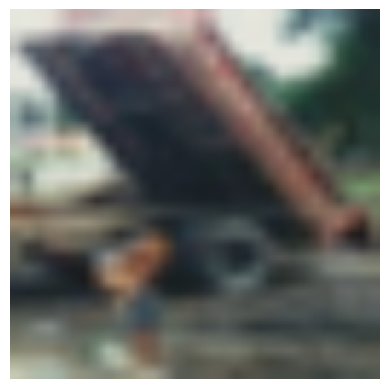

Top 16 Nearest Neighbors (in latent space)


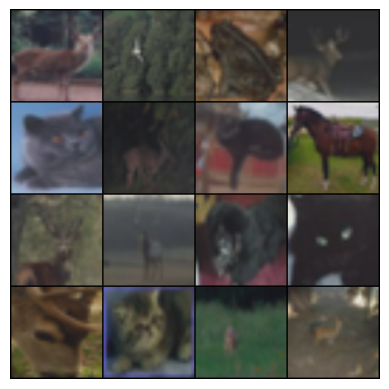

Image 3


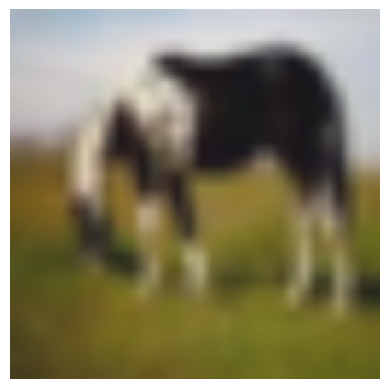

Top 16 Nearest Neighbors (in latent space)


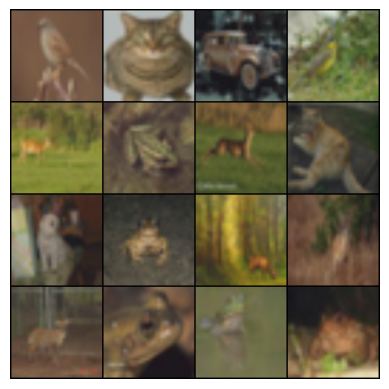

Image 4


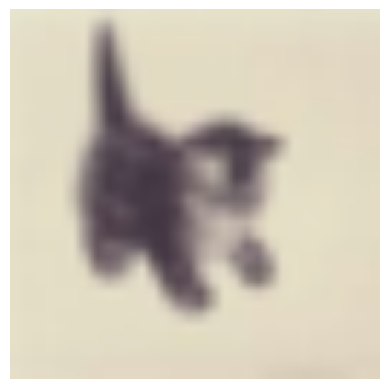

Top 16 Nearest Neighbors (in latent space)


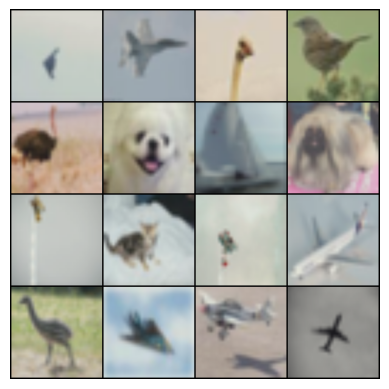

In [17]:
display_nearest_neighbors('context_encoder', model, test_loader)